# Personality Prediction Framework (v4.0) - with fastText

Developed by: R.T.R Jayasekara

## Required Libraries

In [1]:
import pandas
import numpy
import os
import re
import spacy
import warnings
import pickle
import fasttext
import csv
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Preprocessor

In order to work with text data, it is important to transform the raw text into a form that can be understood and used by Machine Learning algorithms, this is called preprocessing.

### Normalizer

In [42]:
def normalizer(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Make the string lower-case
    text = text.lower()
    
    return text

In [43]:
if __name__ == "__main__":
    status_data = pandas.read_csv("datasets/mypersonality_final.csv")

    if not os.path.isfile("datasets/mypersonality_fasttext.csv"):
        # 'y' for 1 and 'n' for 0
        features = ['cEXT', 'cNEU', 'cOPN', 'cAGR', 'cCON']
        for feature in features:
            status_data[feature] = status_data[feature].map({'y': 1, 'n': 0}).astype("string")
            # Add __label__ tags
            status_data[feature]=['__label__'+s.replace(' or ', '$').replace(', or ','$').replace(',','$').replace(' ','_').replace(',','__label__').replace('$$','$').replace('$',' __label__').replace('___','__') for s in status_data[feature]]
        
        status_data['STATUS']= status_data['STATUS'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
        
        # Apply normalizer function to the entire 'STATUS' series
        status_data["STATUS"] = status_data["STATUS"].apply(normalizer)

        status_data.to_csv('datasets/mypersonality_fasttext.csv')
        
    else:
        status_data = pandas.read_csv("datasets/mypersonality_fasttext.csv")

In [44]:
# Drop NAs
status_data = status_data.dropna()

# Drop columns which give us a score for personality type
status_data = status_data.drop(['#AUTHID', 'sEXT', 'sNEU', 'sAGR',
                                    'sCON', 'sOPN', 'DATE'], axis=1)

# Drop non-normalized scores of Brokerage and Betweenness
status_data = status_data.drop(['BROKERAGE', 'BETWEENNESS', 'NBROKERAGE',
                                            'NBETWEENNESS', 'DENSITY', 'TRANSITIVITY', 'NETWORKSIZE'], axis=1)

# Drop unnamed columns
status_data = status_data.drop(status_data.columns[0], axis=1)

In [45]:
status_data.head(10)

,STATUS,cEXT,cNEU,cAGR,cCON,cOPN
0,likes the sound of thunder.,__label__0,__label__1,__label__0,__label__0,__label__1
1,is so sleepy it's not even funny that's she ca...,__label__0,__label__1,__label__0,__label__0,__label__1
2,is sore and wants the knot of muscles at the b...,__label__0,__label__1,__label__0,__label__0,__label__1
3,likes how the day sounds in this new song.,__label__0,__label__1,__label__0,__label__0,__label__1
4,is home. <,__label__0,__label__1,__label__0,__label__0,__label__1
5,www.thejokerblogs.com,__label__0,__label__1,__label__0,__label__0,__label__1
6,"saw a nun zombie, and liked it. also, *propnam...",__label__0,__label__1,__label__0,__label__0,__label__1
7,is in kentucky. miles into her mile journey ...,__label__0,__label__1,__label__0,__label__0,__label__1
8,was about to finish a digital painting before ...,__label__0,__label__1,__label__0,__label__0,__label__1
9,is celebrating her new haircut by listening to...,__label__0,__label__1,__label__0,__label__0,__label__1


In [46]:
# Re-order the dataframe columns
status_data = status_data[['cOPN', 'cCON', 'cEXT', 'cAGR','cNEU', 'STATUS']]

status_data.head(10)

,cOPN,cCON,cEXT,cAGR,cNEU,STATUS
0,__label__1,__label__0,__label__0,__label__0,__label__1,likes the sound of thunder.
1,__label__1,__label__0,__label__0,__label__0,__label__1,is so sleepy it's not even funny that's she ca...
2,__label__1,__label__0,__label__0,__label__0,__label__1,is sore and wants the knot of muscles at the b...
3,__label__1,__label__0,__label__0,__label__0,__label__1,likes how the day sounds in this new song.
4,__label__1,__label__0,__label__0,__label__0,__label__1,is home. <
5,__label__1,__label__0,__label__0,__label__0,__label__1,www.thejokerblogs.com
6,__label__1,__label__0,__label__0,__label__0,__label__1,"saw a nun zombie, and liked it. also, *propnam..."
7,__label__1,__label__0,__label__0,__label__0,__label__1,is in kentucky. miles into her mile journey ...
8,__label__1,__label__0,__label__0,__label__0,__label__1,was about to finish a digital painting before ...
9,__label__1,__label__0,__label__0,__label__0,__label__1,is celebrating her new haircut by listening to...


In [47]:
if not os.path.isfile("fasttext/mypersonality_fasttext_opn.txt"):
    status_data_opn = status_data
    status_data_opn = status_data_opn.drop(['cEXT', 'cNEU', 'cAGR', 'cCON'],axis=1)
    status_data_opn.to_csv('fasttext/mypersonality_fasttext_opn.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_con.txt"):
    status_data_con = status_data
    status_data_con = status_data_con.drop(['cEXT', 'cNEU', 'cOPN', 'cAGR'],axis=1)
    status_data_con.to_csv('fasttext/mypersonality_fasttext_con.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_ext.txt"):
    status_data_ext = status_data
    status_data_ext = status_data_ext.drop(['cNEU', 'cOPN', 'cAGR', 'cCON'],axis=1)
    status_data_ext.to_csv('fasttext/mypersonality_fasttext_ext.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_agr.txt"):
    status_data_agr = status_data
    status_data_agr = status_data_agr.drop(['cEXT', 'cNEU', 'cOPN', 'cCON'],axis=1)
    status_data_agr.to_csv('fasttext/mypersonality_fasttext_agr.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_neu.txt"):
    status_data_neu = status_data
    status_data_neu = status_data_neu.drop(['cEXT', 'cOPN', 'cAGR', 'cCON'],axis=1)
    status_data_neu.to_csv('fasttext/mypersonality_fasttext_neu.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')


    

## Data Visualization

In [48]:
cOPN_counts = status_data['cOPN'].value_counts()
print(cOPN_counts)

cCON_counts = status_data['cCON'].value_counts()
print(cCON_counts)

cEXT_counts = status_data['cEXT'].value_counts()
print(cEXT_counts)

cAGR_counts = status_data['cAGR'].value_counts()
print(cAGR_counts)

cNEU_counts = status_data['cNEU'].value_counts()
print(cNEU_counts)

__label__1    7366
__label__0    2546
Name: cOPN, dtype: int64
__label__0    5358
__label__1    4554
Name: cCON, dtype: int64
__label__0    5706
__label__1    4206
Name: cEXT, dtype: int64
__label__1    5264
__label__0    4648
Name: cAGR, dtype: int64
__label__0    6195
__label__1    3717
Name: cNEU, dtype: int64


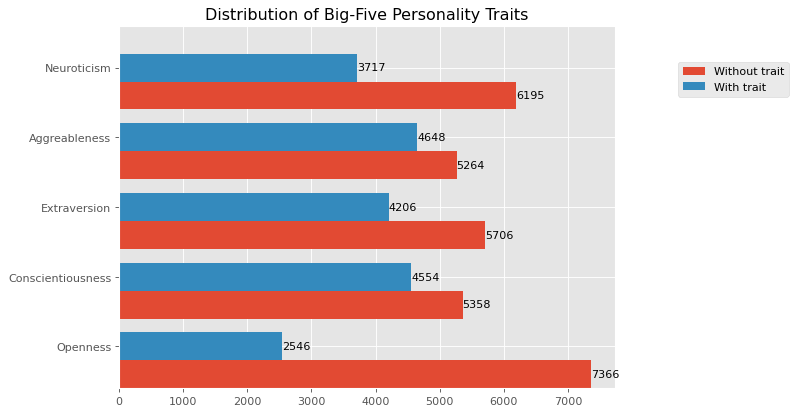

In [49]:
traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Aggreableness', 'Neuroticism']
with_trait_counts = [cOPN_counts[1], cCON_counts[1], cEXT_counts[1], cAGR_counts[1], cNEU_counts[1]]
without_trait_counts = [cOPN_counts[0], cCON_counts[0], cEXT_counts[0], cAGR_counts[0], cNEU_counts[0]]

traits_df = pandas.DataFrame({'with_trait_counts': with_trait_counts, 
                              'without_trait_counts': without_trait_counts,
                              'traits': traits})
ind = numpy.arange(len(traits_df))
width = 0.4

fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.barh(ind, traits_df.without_trait_counts, width, label='Without trait')
ax.barh(ind + width, traits_df.with_trait_counts, width, label='With trait')
ax.set(yticks=ind + width, yticklabels=traits_df.traits, ylim=[2*width - 1, len(traits_df)])
ax.legend(bbox_to_anchor=(1.35, 0.9), loc='upper right', borderaxespad=0)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
plt.title('Distribution of Big-Five Personality Traits')
plt.show()


## FastText Models

fastText is a library for learning of word embeddings and text classification created by Meta's (previously Facebook) AI Research lab.

**Terminal Commands**

```
cd fasttext
```
1) Split into training and test data: 75% and 25%

Total entries = 9916

75% ~~ 7437

50% ~~ 4958

25% ~~ 2479

```
head -n 7437 mypersonality_fasttext_opn.txt > mypersonality_fasttext_opn.train.txt
tail -n 2479 mypersonality_fasttext_opn.txt > mypersonality_fasttext_opn.test.txt

head -n 7437 mypersonality_fasttext_con.txt > mypersonality_fasttext_con.train.txt
tail -n 2479 mypersonality_fasttext_con.txt > mypersonality_fasttext_con.test.txt

head -n 7437 mypersonality_fasttext_ext.txt > mypersonality_fasttext_ext.train.txt
tail -n 2479 mypersonality_fasttext_ext.txt > mypersonality_fasttext_ext.test.txt

head -n 7437 mypersonality_fasttext_agr.txt > mypersonality_fasttext_agr.train.txt
tail -n 2479 mypersonality_fasttext_agr.txt > mypersonality_fasttext_agr.test.txt

head -n 7437 mypersonality_fasttext_neu.txt > mypersonality_fasttext_neu.train.txt
tail -n 2479 mypersonality_fasttext_neu.txt > mypersonality_fasttext_neu.test.txt
```

In [50]:
if not os.path.isfile("fasttext/mypersonality_fasttext_opn.train.txt"):
    status_data_opn.head(7437).to_csv('fasttext/mypersonality_fasttext_opn.train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_con.train.txt"):
    status_data_con.head(7437).to_csv('fasttext/mypersonality_fasttext_con.train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_ext.train.txt"):
    status_data_ext.head(7437).to_csv('fasttext/mypersonality_fasttext_ext.train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_agr.train.txt"):
    status_data_agr.head(7437).to_csv('fasttext/mypersonality_fasttext_agr.train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_neu.train.txt"):
    status_data_neu.head(7437).to_csv('fasttext/mypersonality_fasttext_neu.train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')
####

if not os.path.isfile("fasttext/mypersonality_fasttext_opn.test.txt"):
    status_data_opn.tail(2479).to_csv('fasttext/mypersonality_fasttext_opn.test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_con.test.txt"):
    status_data_con.tail(2479).to_csv('fasttext/mypersonality_fasttext_con.test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_ext.test.txt"):
    status_data_ext.tail(2479).to_csv('fasttext/mypersonality_fasttext_ext.test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_agr.test.txt"):
    status_data_agr.tail(2479).to_csv('fasttext/mypersonality_fasttext_agr.test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')

if not os.path.isfile("fasttext/mypersonality_fasttext_neu.test.txt"):
    status_data_neu.tail(2479).to_csv('fasttext/mypersonality_fasttext_neu.test.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ", encoding = 'utf-8')


In [56]:
def calculate_accuracy(model, feature):
    #Getting data from a CSV
    labels = status_data[feature]
    statuses = status_data['STATUS']
    
    total, correct = 0, 0
    
    for idx, value in statuses.iteritems():
        #Predicting
        predict = model.predict(value, k=1)
        
        #Saving accuracy
        total += 1
        if(predict[0][0] == labels[idx]):
            correct += 1
            
    accuracy = correct / total
    print('accuracy = ' + 'correct/total = '+ str(correct) + '/' + str(total) + ' = ' + str(accuracy) + '\n')

In [52]:
def evaluate_model(dict):
    label_0 = dict['__label__0']
    label_1 = dict['__label__1']
    
    p0 = label_0['precision']
    r0 = label_0['recall']
    f0 = label_0['f1score']
    p1 = label_1['precision']
    r1 = label_1['recall']
    f1 = label_1['f1score']
    
    macro_precision = (p0 + p1) / 2
    macro_recall = (r0 + r1) / 2
    macro_f1 = (f0+ f1) / 2
    
    print('macro_precision = ' + str(macro_precision))
    print('macro_recall = ' + str(macro_recall))
    print('macro_f1 = ' + str(macro_f1))

In [57]:
# Train models using fastText and autotune hyperparameters
model_opn = fasttext.train_supervised('fasttext/mypersonality_fasttext_opn.train.txt', autotuneValidationFile='fasttext/mypersonality_fasttext_opn.test.txt')
model_con = fasttext.train_supervised('fasttext/mypersonality_fasttext_con.train.txt', autotuneValidationFile='fasttext/mypersonality_fasttext_con.test.txt')
model_ext = fasttext.train_supervised('fasttext/mypersonality_fasttext_ext.train.txt', autotuneValidationFile='fasttext/mypersonality_fasttext_ext.test.txt')
model_agr = fasttext.train_supervised('fasttext/mypersonality_fasttext_agr.train.txt', autotuneValidationFile='fasttext/mypersonality_fasttext_agr.test.txt')
model_neu = fasttext.train_supervised('fasttext/mypersonality_fasttext_neu.train.txt', autotuneValidationFile='fasttext/mypersonality_fasttext_neu.test.txt')

In [58]:
predict_opn = model_opn.test_label('fasttext/mypersonality_fasttext_opn.test.txt')
predict_con = model_con.test_label('fasttext/mypersonality_fasttext_con.test.txt')
predict_ext = model_ext.test_label('fasttext/mypersonality_fasttext_ext.test.txt')
predict_agr = model_agr.test_label('fasttext/mypersonality_fasttext_agr.test.txt')
predict_neu = model_neu.test_label('fasttext/mypersonality_fasttext_neu.test.txt')

In [59]:
print('Openness---')
evaluate_model(predict_opn)
calculate_accuracy(model_opn,'cOPN')

print('Conscientiousness---')
evaluate_model(predict_con)
calculate_accuracy(model_con,'cCON')

print('Extraversion---')
evaluate_model(predict_ext)
calculate_accuracy(model_ext,'cEXT')

print('Aggreableness')
evaluate_model(predict_agr)
calculate_accuracy(model_agr,'cAGR')

print('Neuroticism---')
evaluate_model(predict_neu)
calculate_accuracy(model_neu,'cNEU')

Openness---
macro_precision = 0.5789847227234453
macro_recall = 0.5043532338308458
macro_f1 = 0.3797135045508404
accuracy = correct/total = 8843/9912 = 0.8921509281678773

Conscientiousness---
macro_precision = 0.5339004369124851
macro_recall = 0.5334341384686498
macro_f1 = 0.5329243394058756
accuracy = correct/total = 8664/9912 = 0.87409200968523

Extraversion---
macro_precision = 0.6212112431179369
macro_recall = 0.5030767759683422
macro_f1 = 0.4105735385063116
accuracy = correct/total = 5710/9912 = 0.5760694108151735

Aggreableness
macro_precision = 0.4965508058939023
macro_recall = 0.4964567095236734
macro_f1 = 0.48209541204507644
accuracy = correct/total = 8618/9912 = 0.869451170298628

Neuroticism---
macro_precision = 0.6105084822849867
macro_recall = 0.5066277959629023
macro_f1 = 0.3992625332139473
accuracy = correct/total = 6201/9912 = 0.6256053268765133



## Compress Model Files with Quantization

In [61]:
model_opn.quantize(input='fasttext/mypersonality_fasttext_opn.train.txt', retrain=True)
model_con.quantize(input='fasttext/mypersonality_fasttext_con.train.txt', retrain=True)
model_ext.quantize(input='fasttext/mypersonality_fasttext_ext.train.txt', retrain=True)
model_agr.quantize(input='fasttext/mypersonality_fasttext_agr.train.txt', retrain=True)
model_neu.quantize(input='fasttext/mypersonality_fasttext_neu.train.txt', retrain=True)

## Save Trained and Compressed Models 

In [62]:
model_opn.save_model("pickle_files/v4/ppf_ft_opn.ftz")
model_con.save_model("pickle_files/v4/ppf_ft_con.ftz")
model_ext.save_model("pickle_files/v4/ppf_ft_ext.ftz")
model_agr.save_model("pickle_files/v4/ppf_ft_agr.ftz")
model_neu.save_model("pickle_files/v4/ppf_ft_neu.ftz")

In [2]:
loc_v4 = 'pickle_files/v4/'
model_OPN_v4 = fasttext.load_model(loc_v4 + 'ppf_ft_opn.ftz')
model_CON_v4 = fasttext.load_model(loc_v4 + 'ppf_ft_con.ftz')
model_EXT_v4 = fasttext.load_model(loc_v4 + 'ppf_ft_ext.ftz')
model_AGR_v4 = fasttext.load_model(loc_v4 + 'ppf_ft_agr.ftz')
model_NEU_v4 = fasttext.load_model(loc_v4 + 'ppf_ft_neu.ftz')

In [3]:
args_obj = model_OPN_v4.f.getArgs()
for hparam in dir(args_obj):
    if not hparam.startswith('__'):
        print(f"{hparam} -> {getattr(args_obj, hparam)}")

autotuneDuration -> 300
autotuneMetric -> f1
autotuneModelSize -> 
autotunePredictions -> 1
autotuneValidationFile -> 
bucket -> 431137
cutoff -> 0
dim -> 96
dsub -> 2
epoch -> 67
input -> 
label -> __label__
loss -> loss_name.softmax
lr -> 0.05
lrUpdateRate -> 100
maxn -> 0
minCount -> 1
minCountLabel -> 0
minn -> 0
model -> model_name.supervised
neg -> 5
output -> 
pretrainedVectors -> 
qnorm -> False
qout -> False
retrain -> False
saveOutput -> False
seed -> 0
setManual -> <bound method PyCapsule.setManual of <fasttext_pybind.args object at 0x000001D7FA0F8AB0>>
t -> 0.0001
thread -> 12
verbose -> 2
wordNgrams -> 4
ws -> 5


In [4]:
args_obj = model_CON_v4.f.getArgs()
for hparam in dir(args_obj):
    if not hparam.startswith('__'):
        print(f"{hparam} -> {getattr(args_obj, hparam)}")

autotuneDuration -> 300
autotuneMetric -> f1
autotuneModelSize -> 
autotunePredictions -> 1
autotuneValidationFile -> 
bucket -> 89401
cutoff -> 0
dim -> 77
dsub -> 2
epoch -> 39
input -> 
label -> __label__
loss -> loss_name.softmax
lr -> 0.05
lrUpdateRate -> 100
maxn -> 6
minCount -> 1
minCountLabel -> 0
minn -> 3
model -> model_name.supervised
neg -> 5
output -> 
pretrainedVectors -> 
qnorm -> False
qout -> False
retrain -> False
saveOutput -> False
seed -> 0
setManual -> <bound method PyCapsule.setManual of <fasttext_pybind.args object at 0x000001D7FA0F8C70>>
t -> 0.0001
thread -> 12
verbose -> 2
wordNgrams -> 1
ws -> 5


In [5]:
args_obj = model_AGR_v4.f.getArgs()
for hparam in dir(args_obj):
    if not hparam.startswith('__'):
        print(f"{hparam} -> {getattr(args_obj, hparam)}")

autotuneDuration -> 300
autotuneMetric -> f1
autotuneModelSize -> 
autotunePredictions -> 1
autotuneValidationFile -> 
bucket -> 0
cutoff -> 0
dim -> 171
dsub -> 2
epoch -> 100
input -> 
label -> __label__
loss -> loss_name.softmax
lr -> 0.05
lrUpdateRate -> 100
maxn -> 0
minCount -> 1
minCountLabel -> 0
minn -> 0
model -> model_name.supervised
neg -> 5
output -> 
pretrainedVectors -> 
qnorm -> False
qout -> False
retrain -> False
saveOutput -> False
seed -> 0
setManual -> <bound method PyCapsule.setManual of <fasttext_pybind.args object at 0x000001D7FA0F8DB0>>
t -> 0.0001
thread -> 12
verbose -> 2
wordNgrams -> 1
ws -> 5
